In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/'
workingDirectory = '/home/h1bennet/mpsiiia/results/02_201128_Young_CellComp/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

In [3]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_promoters.txt')

In [4]:
mat.columns

Index(['/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/00_mouse_BL6_M_10day_Olig2_ChIP_H3K27ac_1_AL_20200610_CTGTAATC_AATTGCTT',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/00_mouse_BL6_M_10day_Olig2_ChIP_H3K27ac_2_AL_l20200911_AGCTCGCT_GCAGAATC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/02_mouse_BL6_F_8week_Olig2_ChIP_H3K27ac_1_JOS_20190814_GGCTAC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/02_mouse_BL6_M_9week_Olig2_ChIP_H3K27ac_1_JOS_20190809_CAGATC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/03_mouse_MPSIIIAhet_M_4mongh_Olig2_ChIP_H3K27ac_1_AL_l20200925_CTCACCAA_CTAGGCAA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_2_AL_l20200925_GTGAATAT_TCTCATTC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/00_mouse_BL6_M_10day_NeuN_ChIP_H3K27ac_1_AL_20200610_GCCTAGCC_TTGGTCTG',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/02_mouse_BL6_M_3week_NeuN_ChIP_H3K27ac_1_AL_l2

In [5]:
best_reps = ["03_mouse_MPSIIIAhet_M_4mongh_Olig2_ChIP_H3K27ac_1_AL_l20200925_CTCACCAA_CTAGGCAA",
             "03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_2_AL_l20200925_GTGAATAT_TCTCATTC",
             "04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_1_AL_l20200925_ACAGGCGC_CTCTGCCT",
             "04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_2_AL_l20200925_GAACCGCG_TGACCTTA",
             "04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_3_AL_l20200925_TGCGAGAC_CATTGTTG",
             "05_mouse_MPSIIIAhet_PU1_ChIP_H3K27ac_4_month_AL_l20200925_AGGTTATA_CAGTTCCG",
             "05_mouse_MPSIIIAhet_PU1_ChIP_H3K27ac_4_month_AL_l20200925_TCTGTTGG_TCGAATGG",
             "03_mouse_BL6_SOX9_ChIP_H3K27ac_AL_l20200610_ATTATCAA_CGACTCTC",
             "03_mouse_BL6_SOX9_ChIP_H3K27ac_AL_l20200610_GACCAGGA_CTGGCTAT"]

In [6]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_promoters.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./ann_raw_promoters_filtered.txt', sep='\t')

In [7]:
df.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Not Used', 'Focus Ratio/Region Size',
       'Annotation', 'Detailed Annotation', 'Distance to TSS',
       'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene', 'Nearest Refseq',
       'Nearest Ensembl', 'Gene Name', 'Gene Alias', 'Gene Description',
       'Gene Type',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/03_mouse_MPSIIIAhet_M_4mongh_Olig2_ChIP_H3K27ac_1_AL_l20200925_CTCACCAA_CTAGGCAA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_2_AL_l20200925_GTGAATAT_TCTCATTC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_1_AL_l20200925_ACAGGCGC_CTCTGCCT',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_2_AL_l20200925_GAACCGCG_TGACCTTA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_3_AL_l20200925_TGCGAGAC_CATTGTTG',
  

In [12]:
%%bash
source activate deseq_36
getDiffExpression.pl ./ann_raw_promoters_filtered.txt \
00_olig2_4month 00_olig2_4month \
01_neun_4month 01_neun_4month 01_neun_4month \
02_pu1_4month 02_pu1_4month \
03_sox9 03_sox9 \
-peaks -AvsA > ./diff_prom_output.txt


	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_olig2_4month vs. 01_neun_4month:
		Total Genes: 39409
		Total Up-regulated in 01_neun_4month vs. 00_olig2_4month: 7884 (20.006%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_neun_4month vs. 00_olig2_4month: 4700 (11.926%) [log2fold<-1, FDR<0.05]
	Output Stats 00_olig2_4month vs. 02_pu1_4month:
		Total Genes: 39409
		Total Up-regulated in 02_pu1_4month vs. 00_olig2_4month: 4666 (11.840%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 02_pu1_4month vs. 00_olig2_4month: 5305 (13.461%) [log2fold<-1, FDR<0.05]
	Output Stats 00_olig2_4month vs. 03_sox9:
		Total Genes: 39409
		Total Up-regulated in 03_sox9 vs. 00_olig2_4month: 3849 (9.767%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 03_sox9 vs. 00_olig2_4month: 3903 (9.904%) [log2fold<-1, FDR<0.05]
	Output Stats 01_neun_4month vs. 02_pu1_4mont

### Import differential peaks

In [8]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_prom_output.txt',
    './ann_raw_promoters_filtered.txt')


annotatePeaks all peaks (39409, 27)
getDiffExpression selected transcripts (39409, 45)
annotatePeaks selected peaks (39409, 27)


In [20]:
refseq_to_gene = {}
for row in diff_peak.iterrows():
    refseq_to_gene[0] = row[1]['Gene Name']

Check top peaks on browser to ensure everything worked properly

In [9]:
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)
diff_peak.sort_values('00_olig2_4month vs. 01_neun_4month adj. p-value', ascending=True).head()

,Chr,Start,End,Strand,Not Used,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,01_neun_4month vs. 02_pu1_4month Log2 Fold Change,01_neun_4month vs. 02_pu1_4month p-value,01_neun_4month vs. 02_pu1_4month adj. p-value,01_neun_4month vs. 03_sox9 Log2 Fold Change,01_neun_4month vs. 03_sox9 p-value,01_neun_4month vs. 03_sox9 adj. p-value,02_pu1_4month vs. 03_sox9 Log2 Fold Change,02_pu1_4month vs. 03_sox9 p-value,02_pu1_4month vs. 03_sox9 adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
NM_008963,chr2,25467749,25471749,-,0,NaN,promoter-TSS (NM_008963),promoter-TSS (NM_008963),0,NM_008963,...,-2.210766,1.273996e-04,3.623118e-04,-0.638210,0.193842,0.308469,1.483462,0.143628,0.259120,chr2:25467749-25471749
NM_020568,chr17,56107802,56111802,-,0,NaN,promoter-TSS (NM_020568),promoter-TSS (NM_020568),0,NM_020568,...,-2.596351,6.073776e-09,2.462749e-08,0.177305,0.546345,0.660677,2.648818,0.000023,0.000111,chr17:56107802-56111802
NM_001025256,chr18,82552463,82556463,+,0,NaN,promoter-TSS (NM_001025259),promoter-TSS (NM_001025259),0,NM_001025256,...,-1.405489,2.121902e-03,5.113947e-03,-1.463061,0.002471,0.008482,-0.213757,0.819173,0.891029,chr18:82552463-82556463
NM_001025255,chr18,82552463,82556463,+,0,NaN,promoter-TSS (NM_001025259),promoter-TSS (NM_001025259),0,NM_001025255,...,-1.405489,2.121902e-03,5.113947e-03,-1.463061,0.002471,0.008482,-0.213757,0.819173,0.891029,chr18:82552463-82556463
NM_001025251,chr18,82552463,82556463,+,0,NaN,promoter-TSS (NM_001025259),promoter-TSS (NM_001025259),0,NM_001025251,...,-1.405489,2.121902e-03,5.113947e-03,-1.463061,0.002471,0.008482,-0.213757,0.819173,0.891029,chr18:82552463-82556463


In [10]:
# pull out selected samples
cols = np.append(np.asarray([True]*18, 'bool'), peak_mat.columns.str.contains('|'.join(best_reps)))
peaks = peaks.loc[:, cols]
peak_mat = peak_mat.loc[:, peak_mat.columns.str.contains('|'.join(best_reps))]

In [11]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [12]:
comps = ['00_olig2_4month vs. 01_neun_4month',
         '00_olig2_4month vs. 02_pu1_4month',
         '00_olig2_4month vs. 03_sox9',
         '01_neun_4month vs. 02_pu1_4month',
         '01_neun_4month vs. 03_sox9',
         '02_pu1_4month vs. 03_sox9']

cols = [[0,1,2,3,4],
        [0,1,5,6],
        [0,1,7,8],
        [2,3,4,5,6],
        [2,3,4,7,8],
        [5,6,7,8]]

groups = [[[0,1],[2,3,4]],
        [[0,1],[5,6]],
        [[0,1],[7,8]],
        [[2,3,4],[5,6]],
        [[2,3,4],[7,8]],
        [[5,6],[7,8]]]

colors = [['#31a354', '#dd1c77'],
          ['#31a354', '#3182bd'],
          ['#31a354', '#e6550d'],
          ['#dd1c77', '#3182bd'],
          ['#dd1c77', '#e6550d'],
          ['#3182bd', '#e6550d']]

00_olig2_4month vs. 01_neun_4month
N genes downregulated 2305
N genes upregulated 4987

00_olig2_4month vs. 02_pu1_4month
N genes downregulated 3153
N genes upregulated 2860

00_olig2_4month vs. 03_sox9
N genes downregulated 1799
N genes upregulated 2301

01_neun_4month vs. 02_pu1_4month
N genes downregulated 6055
N genes upregulated 4227

01_neun_4month vs. 03_sox9
N genes downregulated 2906
N genes upregulated 2497

02_pu1_4month vs. 03_sox9
N genes downregulated 2577
N genes upregulated 3612



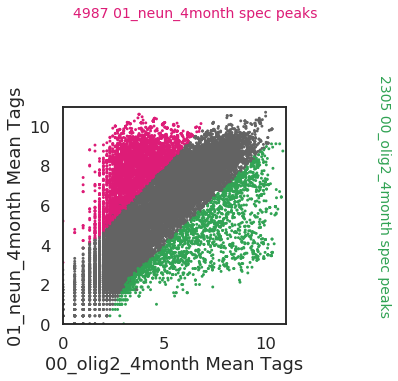

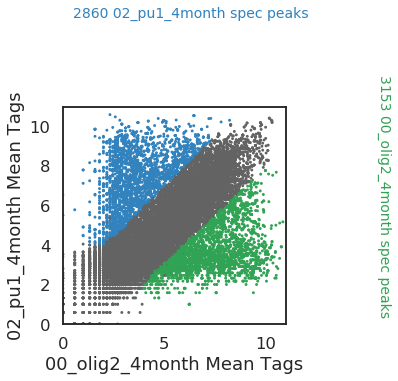

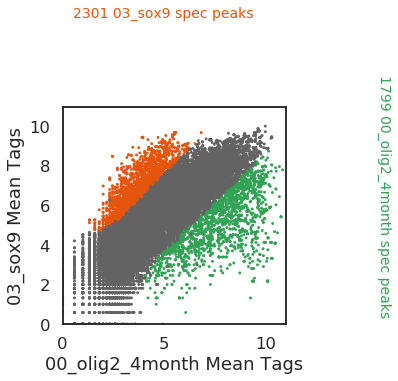

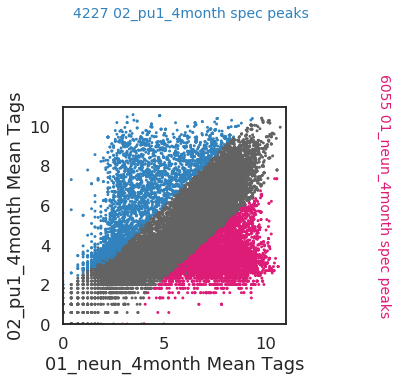

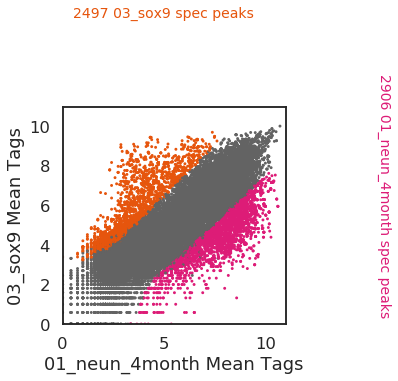

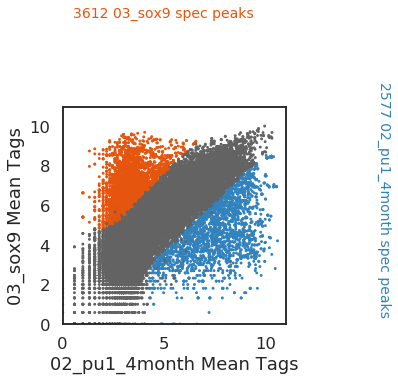

In [20]:
fc = 2
pval = 0.05

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    ## filter lowly expressed peaks
    # filtered = (peak_mat.iloc[:, group[0]].mean(1) >= 5) | (peak_mat.iloc[:, group[1]].mean(1) >= 5)
    # de = de.reindex(peak_mat.index[filtered]).dropna()
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')
#     fig, axs = plt.subplots(1, 2, figsize=(10,6))
#     plt.subplots_adjust(wspace=0.5)

#     axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
#                 right=np.ceil(np.max(np.abs(de.log2fc))))
#     axs[0].scatter(
#         x=de.log2fc,
#         y=de.logtpm,
#         s=dot_sizes, #de.log10p+0.05,
#         c=dot_colors)

#     axs[0].set_ylabel('Mean Log2(TPM)')
#     axs[0].set_xlabel('Log2FC')

#     # plot group by group scatter:
#     axs[1].scatter(
#         x=de.g0_mean,
#         y=de.g1_mean,
#         s=dot_sizes, #de.log10p+0.05,
#         c=dot_colors)
    
#     axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
#     axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
#     #set max and min
#     countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
#     axs[1].set_xlim([0,np.ceil(countmax)])
#     axs[1].set_ylim([0,np.ceil(countmax)])
                      
#     plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
#     plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
#     ax.plot(
#         [0,np.ceil(countmax)],
#         [0,np.ceil(countmax)],
#         ls='--',
#         lw='0.5',
#         c='k')
    
#     ax.plot(
#         [-1,np.ceil(countmax)-1],
#         [0,np.ceil(countmax)],
#         ls='--',
#         lw='0.5',
#         c='k')
    
#     ax.plot(
#         [1,np.ceil(countmax)+1],
#         [0,np.ceil(countmax)],
#         ls='--',
#         lw='0.5',
#         c='k')
    
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,15.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(15.5,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_promoters_scatter.png', bbox_inches='tight')
    # plt.close()

# Clustered heatmap of differential promoters

In [13]:
comps = comp_dict.keys()

## All promoters - z scored

9444


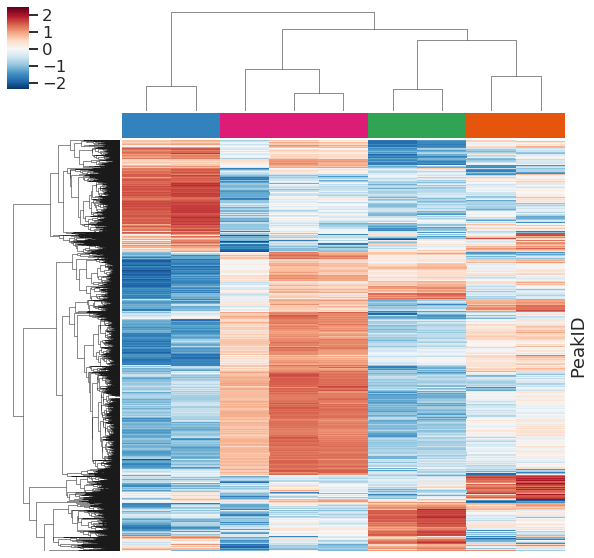

In [22]:
padj = 0.05
fc = 3

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= padj) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#31a354', '#31a354',
                           '#dd1c77', '#dd1c77', '#dd1c77',
                           '#3182bd', '#3182bd',
                           '#e6550d', '#e6550d'],
               yticklabels=0,
               xticklabels=0)
plt.savefig('./figures/diff_promoters_clustermap_zscore.png', bbox_inches='tight')

## All enhancers - log2 tag counts

9444


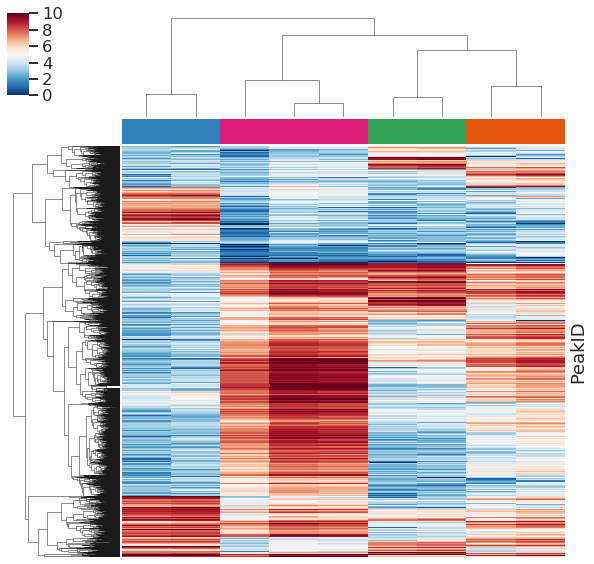

In [23]:
padj = 0.05
fc = 3

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= padj) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               # z_score=0,
               vmin=0,
               vmax=10,
               cmap='RdBu_r',
               col_colors=['#31a354', '#31a354',
                           '#dd1c77', '#dd1c77', '#dd1c77',
                           '#3182bd', '#3182bd',
                           '#e6550d', '#e6550d'],
               yticklabels=0,
               xticklabels=0)
plt.savefig('./figures/diff_promoters_clustermap_log2.png', bbox_inches='tight')

## Top promoters

46


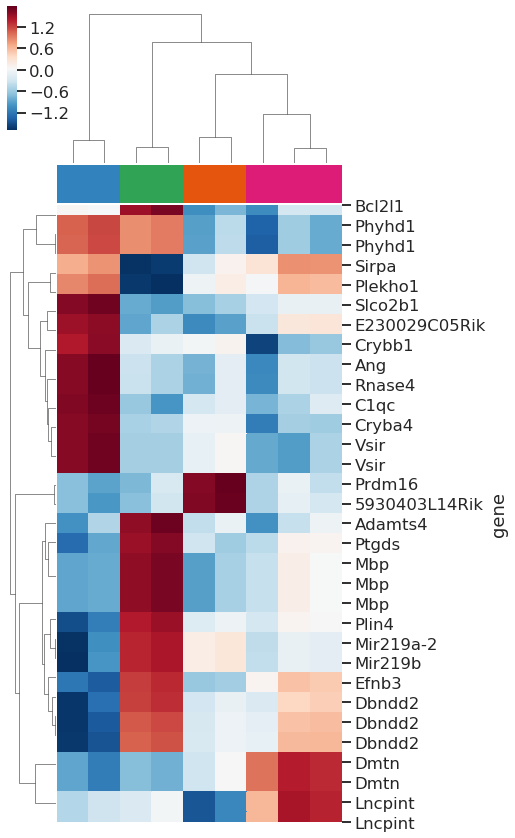

In [31]:
n_top = 20

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.sort_values('adj_pval', ascending=True).index.unique().tolist()[:10])

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks['gene'] = diff_peak.loc[:, 'Gene Name']
sig_peaks = sig_peaks.reset_index().set_index('gene').drop('PeakID', axis=1)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks.drop_duplicates()+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#31a354', '#31a354',
                           '#dd1c77', '#dd1c77', '#dd1c77',
                           '#3182bd', '#3182bd',
                           '#e6550d', '#e6550d'],
               yticklabels=1,
               xticklabels=0,
               figsize=(6,15))
plt.savefig('./figures/diff_promoters_clustermap_top20_zscore.png', bbox_inches='tight')

## Pull cell specific promoters

I want to come up with an automated way to aggregate these comparisons and get a set of unique and overlapping peaks for each possible comparison. This current method solves part of the problem - it automatically pulls out peaks that are unique to one cell type across all comparisons and peaks that are up in at least one pairwise comparison. I think the "intersection" peaks can be used to create the venn diagram style plots

In [82]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['olig2', 'neun', 'pu1', 'sox9']

# set pvalue and fc thresholds
fc = 2
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'promoters')
        print('Intersection set at:', len(i), 'promoters\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing olig2 ...

0
For comp: 00_olig2_4month vs. 01_neun_4month
Union set at: 2305 promoters
Intersection set at: 2305 promoters

1
For comp: 00_olig2_4month vs. 02_pu1_4month
Union set at: 4327 promoters
Intersection set at: 1131 promoters

2
For comp: 00_olig2_4month vs. 03_sox9
Union set at: 4571 promoters
Intersection set at: 831 promoters

3
For comp: 01_neun_4month vs. 02_pu1_4month
Union set at: 4571 promoters
Intersection set at: 831 promoters

3
For comp: 01_neun_4month vs. 03_sox9
Union set at: 4571 promoters
Intersection set at: 831 promoters

3
For comp: 02_pu1_4month vs. 03_sox9
Union set at: 4571 promoters
Intersection set at: 831 promoters

Analyzing neun ...

0
For comp: 00_olig2_4month vs. 01_neun_4month
Union set at: 4987 promoters
Intersection set at: 4987 promoters

1
For comp: 00_olig2_4month vs. 02_pu1_4month
Union set at: 4987 promoters
Intersection set at: 4987 promoters

1
For comp: 00_olig2_4month vs. 03_sox9
Union set at: 4987 promoters
Intersection set a

### plot specific peaks

In [86]:
for key in peak_lists.keys():

    sns.clustermap(np.log2(peak_mat.loc[peak_lists[key], :]+1),
                   z_score=0,
                   cmap='RdBu_r',
                   col_colors=['#31a354', '#31a354',
                               '#dd1c77', '#dd1c77', '#dd1c77',
                               '#3182bd', '#3182bd',
                               '#e6550d', '#e6550d'],
                   yticklabels=0,
                   xticklabels=0,
                   vmin=-2,
                   vmax=2,
                   figsize=(6,15))
    
    plt.savefig('./figures/promoter_heatmap_'+key+'.png', bbox_inches='tight')
    plt.close()

### save cell specific promoters for gene enrichment analysis

In [110]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists/')

In [112]:
for key in peak_lists.keys():
    with open('./gene_lists/'+key+'_genes.txt', 'w') as f:
        f.write('gene\n')
        for gene in diff_peak.reindex(peak_lists[key]).dropna(how='all').loc[:, 'Gene Name'].tolist():
            f.write(str(gene)+'\n')
        f.close()

## Save differential promoters for motif analysis
Homer should theoretically work with 4 kb promoters but execution might take a while.

In [88]:
if not os.path.isdir('./promoter_motif_calling/'):
    os.mkdir('./promoter_motif_calling/')

In [95]:
for key in peak_lists.keys():
    # save cell specific promoters
    diff_peak.reindex(peak_lists[key]).dropna(how='all').to_csv(
        './promoter_motif_calling/'+key+'_act_peaks.txt',
        sep='\t')
    
    # save all other promoters as a background peak set
    diff_peak.reindex(diff_peak.index.difference(peak_lists[key])).dropna(how='all').to_csv(
        './promoter_motif_calling/'+key+'_bg_peaks.txt',
        sep='\t')

### Find motifs

In [103]:
%%bash
# delete the existing script file
rm ./findMotifs_promoter_homer.sh
# create a script file
touch ./findMotifs_promoter_homer.sh

In [104]:
%%bash
for i in ./promoter_motif_calling/*union*act*;
do bg_file=${i/act/bg};
out=${i/.txt/_motifs};
echo "findMotifsGenome.pl $i mm10 $out -bg $bg_file -len 8,10,12,14,16 -size given &" >> ./findMotifs_promoter_homer.sh
done